## setup

In [1]:
from utils import *
import pandas as pd

In [2]:
import numpy as np

In [3]:
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import colors

In [4]:
import random
random.seed(42)

In [5]:
import itertools

In [6]:
from datetime import datetime

In [7]:
set_workspace("/Users/roccc/Desktop/Projects/HenanFlood/")

workspace has been set at /Users/roccc/Desktop/Projects/HenanFlood.


In [8]:
pd.set_option('display.max_colwidth', None)

In [9]:
# import sci_palettes
# print(sci_palettes.PALETTES.keys())

# sci_palettes.register_cmap()          # register all palettes
# sci_palettes.register_cmap('aaas')    # register a special palette
# plt.set_cmap('aaas')
# plt.set_cmap('jama')

# plt.style.use('aaas')

# import seaborn as sns
# sns.set_theme(palette='aaas')
# sns.set_palette('aaas')

In [10]:
import matplotlib
matplotlib.rcParams['font.sans-serif']=['SimSun','KaiTi','SimHei','FangSong']   # 用黑体显示中文
matplotlib.rcParams['axes.unicode_minus']=False 

In [11]:
# weibo_not_xians_topicI_distribution.index
topics_index = ['事件基本信息','应急行动进展','预警与建议','救援需求信息','建筑设施与公共事业','公众舆情','其他','援助信息']

### 用到的函数

In [12]:
def str2date(string, mode='%Y%m%d'):
    return datetime.date(datetime.strptime(string,mode))

In [13]:
def save_as_json(data, filename, mode='w'):
    with open(filename, mode, encoding='utf-8') as fh:
        json.dump(data, fh, ensure_ascii=False, indent=4, use_decimal=True,)

In [14]:
def update_by_content(item, contents):
    weibo_id, address = item
    content = contents.get(weibo_id)
    new_address = []
    for add in address:
        if add in content:
            new_address.append(add)
    return (weibo_id, new_address)

In [15]:
def weibo_filter_by_address(weibo_with_addr, target_addr_list):
    '''check addr_list of weibo if it contains addr in target_addr_list, 
    if so, return weibo_id and its addr_list '''

    weibo_id, addr_list = weibo_with_addr
    addr_text = ' '.join(addr_list)
    is_in = sum(list(map(lambda x: x in addr_text, target_addr_list)))
    
    return is_in

In [16]:
# os.chdir('./..')

#### 对比分析用到的函数

In [17]:
# grouper_day = pd.Grouper(key='publish_time', axis=0, sort=True,freq='D')
phases = {
    '0': ['2021-07-10', '2021-07-19'],
    '1': ['2021-07-20', '2021-07-24'],
    '2': ['2021-07-25', '2021-07-30'],
    '3': ['2021-07-31', '2021-08-31']
}
def mapping_phases(date,phases_mapper):
    date = str(date)[:10]
    if date <= phases_mapper['0'][1]:
        return '0'
    elif date <= phases_mapper['1'][1]:
        return '1'
    elif date <= phases_mapper['2'][1]:
        return '2'
    elif date <= phases_mapper['3'][1]:
        return '3'
    else:
        return '-1'
def build_weibos_analysis_df(weibos_dict):
    df = pd.DataFrame(pd.Series(weibos_dict))
    df['content'] = df.index.map(contents)
    df['sentiment'] = df.index.map(sentiments_labeled)
    df['topic_I'] = df.index.map(topics_labeled_I)
    df['topic_II'] = df.index.map(topics_labeled_II)
    df['publish_time'] = df.index.map(publish_time)
    df['publish_time'] = pd.to_datetime(df['publish_time']).dt.date
    df['phase'] = df['publish_time'].apply(lambda x:mapping_phases(x, phases))
    return df

def get_vol_ts(df):
    ts = df.groupby('publish_time')[0].count()
    return ts

def get_senti_ts(df, aggfunc='count'):
    senti_ts = pd.pivot_table(df,index='publish_time', columns='sentiment', aggfunc=aggfunc, fill_value=0)[0]
    return senti_ts

def get_topic_ts(df, topic_lv=1, aggfunc='count'):
    if topic_lv == 1:
        ts = pd.pivot_table(df, index='publish_time', columns='topic_I', aggfunc=aggfunc, fill_value=0)[0]
    else:
        ts = pd.pivot_table(df, index='publish_time', columns='topic_II', aggfunc=aggfunc, fill_value=0)[0]
    return ts

In [18]:
def plot_time_series(df,time_span='all',log_norm=False):
    # setup
    if time_span == 'all':
        time_span = ['2021-07-10','2021-07-20','2021-07-25','2021-07-31','2021-08-31']
    else:
        time_span = ['2021-07-19','2021-07-20','2021-07-25','2021-07-30','2021-07-31']
    x_phase = list(map(lambda x :datetime.strptime(x, '%Y-%m-%d'), time_span))
    
    # 
    color_panel = ['#E64B35FF','#4DBBD5FF','#00A087FF','#3C5488FF','#F39B7FFF','#8491B4FF',
    #               ]
                   '#91D1C2FF','#DC0000FF','7E6148FF','B09C85FF']
    marker_panel = ['2','s','p','*','+','-','D','.','o','v']

    max_ = ((df.max().max() // 1000)+2) * 1000
    
    # draw
    fig, ax = plt.subplots(figsize=(12, 4), dpi=200)

    ax.set_ylim(bottom=0, top=max_)
    ax.set_xlim(x_phase[0],x_phase[-1])
    if log_norm:
        ax.set_yscale('log')

    # 设置x轴具体刻度显示
    formatter = plt.FuncFormatter(time_ticks)
    ax.xaxis.set_major_formatter(formatter)

    # X轴的间隔为天
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gcf().autofmt_xdate()  
    
    # 对统计的不同类别数量分别绘制线图
    for col, color, marker in zip(df.columns, 
                                 color_panel, 
                                 marker_panel):
        if col != '一般救援需求':
            ax.plot(df.index.values, df[col].values, f'-{marker}', 
                    color=color,
                    label=col
                   )

    y = np.linspace(0,max_,50)
    for _x in x_phase[1:-1]:
        ax.plot([_x]*50, y, '|', markersize=3, color='grey')


    ax.legend()
#     ax.set_title('河南暴雨微博舆情城乡每日微博发布数量时序图', fontdict={
#                  'fontsize': '20', 'fontweight': '1'})

    plt.show()

In [19]:
def time_ticks(x, pos):
    x = mdates.num2date(x)
    # 时间坐标是从坐标原点到结束一个一个标出的
    # 如果是坐标原点的那个刻度则用下面的要求标出刻度
    if pos in (0,22):
        # %Y-%m-%d
        # 时间格式化的标准是按 2020-10-01 10:10:10.0000 标记的
        fmt = '%m.%d'
    # 如果不是是坐标原点的那个刻度则用下面的要求标出刻度
    else:
        # 时间格式化的标准是按 10:10:10.0000 标记的
        fmt = '%d'
    # 根据 fmt 的要求画时间刻度
    label = x.strftime(fmt)
    
    # 当 fmt 有%s时需要下面的代码
#     label = label.rstrip("0")
#     label = label.rstrip(".")
    
    # 截断了秒后面的 .000
    return label

def senti_stats_plot(senti_stats):
    # setup
    x_phase = list(map(lambda x :datetime.strptime(x, '%Y-%m-%d'), ['2021-07-10','2021-07-20','2021-07-25','2021-07-31','2021-08-31']))
    # 
    color_panel = ['#ffc620','#00dced','#9f00ff','#ff0061','#083356','#3FB568',]
                   #'#576aff','#ffc688']
    marker_panel = ['2','s','p','*','+','-']

    # draw
    fig, ax = plt.subplots(figsize=(12, 6), dpi=200)

    ax.set_ylim(bottom=1, top=1000000)
    ax.set_yscale('log')
    ax.set_xlim(x_phase[0],x_phase[-1])

    # # 设置x轴具体刻度显示

    # ax.xaxis.seajor_formatter(mdates.DateFormatter('%m.%d'))
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
    # 根据自己定义的方式去画时间刻度
    formatter = plt.FuncFormatter(time_ticks)
    ax.xaxis.set_major_formatter(formatter)

    #X轴的间隔为小时
    # ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gcf().autofmt_xdate()  


    for col, color,marker in zip(senti_stats.columns, color_panel, marker_panel):
        ax.plot(senti_stats.index.values, senti_stats[col].values, f'-{marker}', color=color)

    # y = np.logspace(1,10,100000)
    # y = [1,5,10,50,100,500,1000,5000,10000,50000,100000,500000,1000000]
    y = np.logspace(0,6,50)
    for _x in x_phase[1:-1]:
        ax.plot([_x]*50, y, '|', markersize=3, color='grey')


    ax.legend(senti_stats.columns)
    # ax.set_title('河南暴雨微博舆情不同情感每日微博发布数量时序图', fontdict={
    #              'fontsize': '15', 'fontweight': '1'})

    plt.show()

In [20]:
def senti_ratio_stack_plot(senti_stats_r):
    x_phase = list(map(lambda x :datetime.strptime(x, '%Y-%m-%d'), ['2021-07-10','2021-07-20','2021-07-25','2021-07-31','2021-08-31']))
    # 占比图
    color_panel = ['#ffc620','#00dced','#9f00ff','#ff0061','#083356','#3FB568',]
                   #'#576aff','#ffc688']
    marker_panel = ['2','s','p','*','+','-']
    fig, ax = plt.subplots(1,figsize=(12, 6), dpi=200)
    # color_panel = ['#ffc620','#00dced','#9f00ff','#ff0061','#083356','#3FB568','#576aff','#ffc688']
    ax.set_ylim(0,1)
    ax.set_xlim(x_phase[0],x_phase[-1])
    ax.stackplot(senti_stats_r.index.values, senti_stats_r.values.T, labels=senti_stats_r.columns.values,colors=color_panel)
    # ax.legend()
    y = np.linspace(0,1,30)
    for _x in x_phase[1:-1]:
        ax.plot([_x]*30, y, '|', markersize=3, color='black')
    ax.legend(labels=senti_stats_r.columns.values, loc='lower right')
    # ax.set_title('河南暴雨微博舆情不同情感每日微博发布数量占比时序图', fontdict={
    #              'fontsize': '15', 'fontweight': '1'})
    # ax.set_yscale('log')
    plt.show()
    
def senti_ratio_line_plot(senti_stats_r):
    fig, ax = plt.subplots(figsize=(12, 6), dpi=200)
    x_phase = list(map(lambda x :datetime.strptime(x, '%Y-%m-%d'), ['2021-07-10','2021-07-20','2021-07-25','2021-07-31','2021-08-31']))
    # 占比图
    color_panel = ['#ffc620','#00dced','#9f00ff','#ff0061','#083356','#3FB568',]
                   #'#576aff','#ffc688']
    marker_panel = ['2','s','p','*','+','-']
    ax.set_ylim(bottom=0, top=1)
    # ax.set_yscale('log')
    ax.set_xlim(x_phase[0],x_phase[-1])

    for col, color,marker in zip(senti_stats_r.columns, color_panel, marker_panel):
        ax.plot(senti_stats_r.index.values, senti_stats_r[col].values, f'-{marker}', color=color)

    y = np.linspace(0,1,30)
    for _x in x_phase[1:-1]:
        ax.plot([_x]*30, y, '|', markersize=3, color='grey')
    ax.legend(senti_stats_r.columns)
    # ax.set_title('河南洪灾微博舆情不同情感每日微博发布数量占比时序图', fontdict={
    #              'fontsize': '15', 'fontweight': '1'})

    plt.show()

## 加载数据集

In [21]:
#addresses_all = open_json('./data/results/addresses.json')

In [21]:
sentiments = open_json('./data/results/weibos_sentiment_614000.json')

In [22]:
sentiment_label_mapping = {'Angry':0,'Positive':1,'Neutral':2,'Surprised':3,'Scared':4,'Sad':5,'NULL':-1}
label_mapping_r = dict(map(lambda x: (x[1],x[0]), sentiment_label_mapping.items() ))
sentiments_labeled = dict(map(lambda x: (x[0], label_mapping_r[x[1]]), sentiments.items()))

In [23]:
topics = open_json('./data/results/weibos_topic_614000.json')

In [24]:
topics_mapper = open_json('./data/results/topics_mapping0312.json')
topic_mapper_2 = {'A':'援助信息','B':'救援需求信息','C':'事件基本信息','D':'建筑设施及公共事业','E':'应急行动进展','F':'预警与建议','G':'公众舆情','H':'其他','NULL':'NULL'}
# topic_mapper_2 = {'A':'帮助','B':'求助','C':'基本信息','D':'设施','E':'应急进展','F':'预警','G':'舆情','H':'其他'}
topics_labeled_II = dict(map(lambda x: (x[0], topics_mapper[x[1]][1]), topics.items()))
topics_labeled_I = dict(map(lambda x: (x[0], topic_mapper_2[topics_mapper[x[1]][0]]), topics.items()))

In [25]:
publish_time_list = open_json('./data/results/weibo_publish_time.json')
publish_time = dict(map(lambda x: (x[0],x[1]), publish_time_list))

In [26]:
contents_list = open_json('./data/cleaned_data/weibos_content_1124.json')

In [27]:
contents = dict(map(lambda x: (x.get('weibo_id'),x.get('content')), contents_list))

In [28]:
# 全部有文本的微博
weibos_df = build_weibos_analysis_df(topics)

In [29]:
# 筛选救援需求类微博，
weibos_topic_B = dict(map(lambda x:(x[0],x[1]), filter(lambda x: x[1]=='救援需求信息', topics_labeled_I.items())))
# build_weibos_analysis_df()

In [30]:
weibos_df_topic_B = build_weibos_analysis_df(weibos_topic_B)

In [31]:
weibos_df_topic_B.topic_II.value_counts()

B3    152254
B1     56491
B2     11164
B4      8909
Name: topic_II, dtype: int64

### 城乡抽取和check，用市 与 区县 两级行政名称取出含有有效地址的微博 

In [32]:
addresses_updated = open_json('./data/results/addresses_614000.json')

In [33]:
addresses_updated_valid = dict(filter(lambda x: x[1], addresses_updated.items()))

In [34]:
admins_by_level = open_json('./data/results/admin_divisions.json')

In [35]:
cities = list(filter(lambda district: district[0][:2] == '41', admins_by_level.get('city')))

In [36]:
cities_for_match = list(map(lambda x: x[1][:-1], cities))

In [37]:
districts = list(filter(lambda district: district[0][:2] == '41', admins_by_level.get('district')))

In [38]:
districts_for_match = list(map(lambda x: x[1][:2] if len(x[1])<4 else x[1], districts))

In [39]:
# 注意，包含城市地名的，可能也包含乡村；因此用城市匹配出来的，需要用乡村的清洗一下

In [40]:
weibos_addr_cities = dict(filter(lambda x: weibo_filter_by_address(x, cities_for_match), addresses_updated_valid.items()))

In [41]:
weibos_addr_districts = dict(filter(lambda x: weibo_filter_by_address(x, districts_for_match), addresses_updated_valid.items()))

In [42]:
weibo_add_valid = weibos_addr_cities.copy()

In [43]:
weibo_add_valid.update(weibos_addr_districts)

In [44]:
len(weibo_add_valid)

62265

check 二级与三级 同名的行政区划，包括三个：安阳，新乡，濮阳；需单独处理；

含有效地址的微博共计62265条。

## 整体微博的图

In [45]:
# weibos_df.head()

In [46]:
weibos_topic_ts = get_topic_ts(weibos_df, topic_lv=1)

In [47]:
# plot_time_series(weibos_topic_ts)

## 救援需求中四个需求的时序图

In [48]:
# weibos_df_topic_B.loc[weibos_df_topic_B.topic_II=='B3'].sample(n=50)

In [49]:
weibos_df_topic_B_rectify = weibos_df_topic_B.copy()
weibos_df_topic_B_rectify['topic_II'] = weibos_df_topic_B[['topic_II','content']].apply(lambda x: 'B1' if x[0]=='B3' and x[1]=='#河南暴雨互助#' else x[0],axis=1)

In [50]:
weibos_df_topic_B_rectify['topic_II'].value_counts()

B1    190389
B3     18356
B2     11164
B4      8909
Name: topic_II, dtype: int64

#### topic

In [51]:
topics_B_ts = get_topic_ts(weibos_df_topic_B_rectify, topic_lv='2')

In [52]:
# topics_B_ts.head()
topics_B_ts.columns = ['一般救援需求', "应急物资需求", "人员搜寻需求", "紧急转移需求"]

In [53]:
topics_B_ts.max().max()

76137

In [54]:
datetime.date(datetime.strptime('20210720','%Y%m%d'))

datetime.date(2021, 7, 20)

In [55]:
# topics_B_ts_0720_0730 = topics_B_ts.loc[str2date('20210720'):str2date('20210730')]
topics_B_ts_0720_0730 = topics_B_ts.loc[str2date('20210719'):str2date('20210731')]

In [57]:
# plot_time_series(np.power(topics_B_ts[["生活物资需求", "寻人信息", "紧急转移需求"]],0.5))
# plot_time_series(topics_B_ts[["生活物资需求", "寻人信息", "紧急转移需求"]])
# plot_time_series(topics_B_ts.loc['2021-07-10':'2021-07-20',["生活物资需求", "寻人信息", "紧急转移需求"]])
# plot_time_series(topics_B_ts_0720_0730[["物资需求", "寻人需求", "紧急转移需求"]])

#### sentiment

In [58]:
# weibos_df_topic_B_rectify.sentiment.value_counts()

In [56]:
senti_B_ts = get_senti_ts(weibos_df_topic_B_rectify)

In [60]:
# senti_B_ts.Neutral.value_counts()

In [61]:
# plot_time_series(senti_B_ts.iloc[:,[0,2,3,4,5]])

## 比较分析 县，与区（市）

update by 2021 吉利区, 孟津县->孟津区

In [57]:
districts_xian = list(filter(lambda x: '县' == x[1][-1], districts))
districts_xian_for_match = list(map(lambda x: x[1][:2] if len(x[1])<4 else x[1], districts_xian))
districts_xian_for_match.remove('孟津')

In [58]:
districts_not_xian = list(filter(lambda x: '县'!= x[1][-1], districts))
districts_not_xian_for_match = list(map(lambda x: x[1][:2] if len(x[1])<4 else x[1], districts_not_xian))
districts_not_xian_for_match.append('孟津')
districts_not_xian_for_match.remove('吉利')

In [59]:
weibos_addr_not_xians = dict(filter(lambda x: weibo_filter_by_address(x, districts_not_xian_for_match), weibo_add_valid.items()))

### 基于上述核验，三地要单独处理：
- 命中'xx县'，归到县级；

In [60]:
districts_xian_for_match_new = list(map(lambda x: x[1][:2] if len(x[1])<4 and x[1][:2] not in ('安阳','濮阳','新乡') else x[1], districts_xian))
districts_xian_for_match_new.remove('孟津')

In [61]:
weibos_addr_xians_new = dict(filter(lambda x: weibo_filter_by_address(x, districts_xian_for_match_new), weibo_add_valid.items()))

In [62]:
len(weibos_addr_xians_new)

7755

In [63]:
weibo_xians = build_weibos_analysis_df(weibos_addr_xians_new)

In [89]:
weibo_not_xians = build_weibos_analysis_df(weibos_addr_not_xians)

In [90]:
weibo_not_xians.shape

(22487, 7)

### 验证，将含有“村”“镇”的并入县，

In [66]:
#村 或 镇

In [67]:
# cun_keywords = ['村庄','村里','全村','农村','农村','乡镇','庄村','村民','村支书','村委']
cun_keywords = ['村','镇']

In [91]:
weibo_xians_cun = weibo_not_xians[weibo_not_xians['content'].apply(lambda x: sum(list(map(lambda y: y in x, cun_keywords)))) > 0]

#### 验证 not xian中 含有 村 or 镇的内容

In [69]:
weibo_xians_add_cun = pd.concat([weibo_xians, weibo_xians_cun], axis=0)

In [92]:
weibo_not_xians = weibo_not_xians[weibo_not_xians['content'].apply(lambda x: sum(list(map(lambda y: y in x, cun_keywords)))) == 0]

In [93]:
weibo_not_xians.shape

(18277, 7)

### 验证，区（市）与县并提的情况

In [72]:
# weibo_xians_cun.shape
# save_as_json(weibo_xians_cun.index.tolist(), './data/cleaned_data/weibo_id_village.json')

### 时序

In [73]:
# weibo_xians_add_cun.columns

In [74]:
weibo_xians_vol_ts = get_vol_ts(weibo_xians_add_cun)

In [75]:
weibo_not_xians_vol_ts = get_vol_ts(weibo_not_xians)

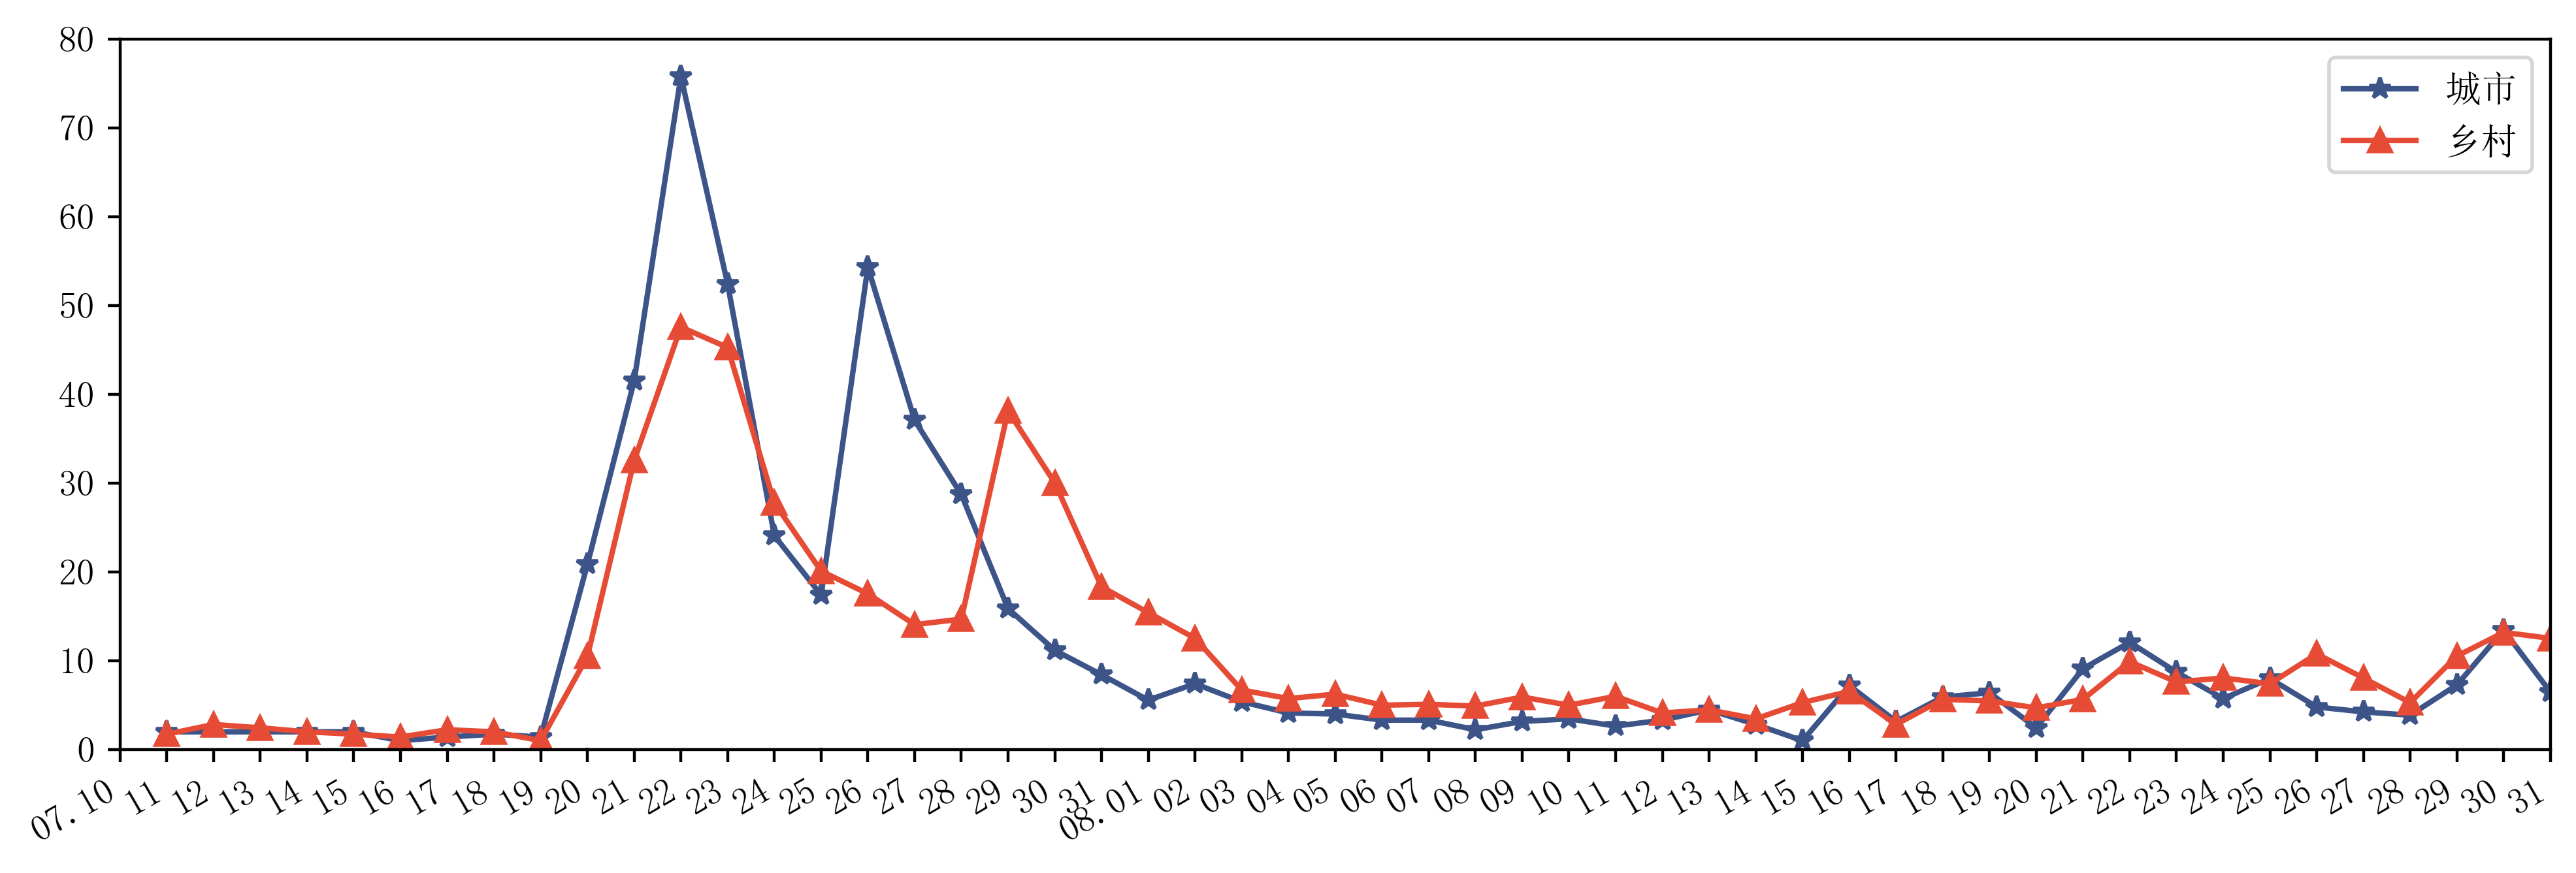

In [83]:
# setup
x_phase = list(map(lambda x :datetime.strptime(x, '%Y-%m-%d'), ['2021-07-10','2021-07-20','2021-07-25','2021-07-31','2021-08-31']))
# 
# color_panel = ['#E64B35FF','#4DBBD5FF','#00A087FF','#3C5488FF','#F39B7FFF','#8491B4FF',]
color_panel = ['#4DBBD5FF','#E64B35FF','#00A087FF','#3C5488FF','#F39B7FFF','#8491B4FF','#91D1C2FF','#DC0000FF','7E6148FF','B09C85FF']
#                '#91D1C2FF','#DC0000FF','7E6148FF','B09C85FF']
marker_panel = ['2','s','p','*','+','-']

# draw
fig, ax = plt.subplots(figsize=(12, 4), dpi=400)
# ax.set_yscale('log')
ax.set_ylim(bottom=0, top=80)
ax.set_xlim(x_phase[0],x_phase[-1])

# # 设置x轴具体刻度显示
formatter = plt.FuncFormatter(time_ticks)
ax.xaxis.set_major_formatter(formatter)

#X轴的间隔为小时
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()  
# for col, color, marker in zip(senti_stats.columns, 
#                              color_panel, 
#                              marker_panel):
#     ax.plot(senti_stats.index.values, senti_stats[col].values, f'-{marker}', 
#             color=color
#            )
ax.plot(np.power(weibo_not_xians_vol_ts,0.5),'-*', color='#3C5488FF', label='城市')
ax.plot(np.power(weibo_xians_vol_ts,0.5),'-^',color='#E64B35FF', label='乡村')

y = np.linspace(0,6000,50)
for _x in x_phase[1:-1]:
    ax.plot([_x]*50, y, '|', markersize=1, color='grey')


ax.legend()
# ax.set_title('河南暴雨微博舆情城乡每日微博发布数量时序图', fontdict={
#              'fontsize': '20', 'fontweight': '1'})
    
plt.show()

关于县的舆情1. 数量少；2. 滞后性;

#### 检查波峰的事件

In [84]:
weibo_xians_add_cun_0726 = weibo_xians_add_cun[weibo_xians_add_cun['publish_time'].astype(str) == '2021-07-26']

In [95]:
weibo_not_xians_0726 = weibo_not_xians[weibo_not_xians['publish_time'].astype(str) == '2021-07-26']
weibo_not_xians_0726['content'].sample(10)

KqvisBmT0                                                                                        #卫辉暴雨##卫辉内涝#
KqyEInnAD                                                                                            #新乡卫辉暴雨#
Kqxv2t3u9                                                                                         #为卫辉让出救援通道#
KqzWE4gEy                                                                                            扩！#卫辉暴雨#
KqxAFdjy5                                                                                              #卫辉内涝#
KqvebuHmi                                                                                              #卫辉内涝#
KqyI5mAjN                                                                                  #卫辉内涝##卫辉求助##卫辉暴雨#
KquXf3z22    河南卫辉全城水深达到2米以上，全部被淹，近60万人受灾急需游艇，大型抽水设备排涝，肯请有能力的单位组织和个人来帮助救灾！吃的喝的已够，急需排涝设备！救援设备！希望看到朋友转发一下，救救卫辉吧！
Kqxvss8Do                                                                                        #为卫辉让出救援通道#扩
Kqy7rzHOW 

In [102]:
weibo_xians_add_cun_0729 = weibo_xians_add_cun[weibo_xians_add_cun['publish_time'].astype(str) == '2021-07-29']
weibo_xians_add_cun_0722 = weibo_xians_add_cun[weibo_xians_add_cun['publish_time'].astype(str) == '2021-07-22']
weibo_xians_add_cun_0723 = weibo_xians_add_cun[weibo_xians_add_cun['publish_time'].astype(str) == '2021-07-23']

In [97]:
weibo_not_xians_0722 = weibo_not_xians[weibo_not_xians['publish_time'].astype(str) == '2021-07-22']

In [99]:
weibo_not_xians_0722['content'].sample(10)

KpPMthtq9                                                                            #卫辉暴雨#看看卫辉!!!!
KpV5f0063                                                                                    #辉县暴雨#
KpTvz5zMD                                                                                    #卫辉暴雨#
KpSjKwKdk                                                                 #河南暴雨互助##卫辉暴雨#卫辉急需救援团队和物资
KpTsTAOb3    #辉县暴雨##河南暴雨互助##新乡暴雨#求求大家关注一下辉县这个小地方！！！现在下雨是第一，救援和物资都很少，求求求求了🙏🙏🙏🙏🙏🙏07月22日10:58关注她举报收藏操作
KpTIOlkKs                                                                    #河南暴雨救援##河南暴雨互助##卫辉暴雨#
KpVUR6gUQ                                                                           凤泉区求助‼️#河南暴雨互助#
KpTJmxspj                                                                                       卫辉❗
KpRYx3kCe                                                                                    #卫辉暴雨#
KpYd894NW                                                                          #新乡辉县暴雨##河南暴雨互助#


In [101]:
weibo_xians_add_cun_0722['content'].sample(10)

KpU70uKAO                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   #郑州[超话]##河南暴雨救援#荥阳市刘河镇位于郑州南部山区，受到严重暴雨灾害，全镇受灾群众2300余人，后续次生灾害威胁大，物资告急！现急需：生活物资：饮用水、方便食品、蔬菜、救灾帐篷、被褥、衣服、雨衣、胶鞋，卫生棉等；救援物资：发电机、汽柴油、应急照明设备、消毒防疫物品、对讲机和应急药品等；垦请社会各界伸出援助之手，帮助受灾群众渡过难关！！捐赠地址：刘河镇人民政府（庙王路南500米，导航可到）联系人：刘河镇人大主席法延钊13838396222刘河镇党政办姚雨1551711978907月22日12

In [103]:
weibo_xians_add_cun_0723['content'].sample(10)

KpZwvmPIW                                                                                                                                                                        #新乡##河南暴雨互助##辉县卫辉等58个乡镇受灾#请大家帮帮我们的城市，帮忙转发扩散🙏截至目前是受灾的第二个晚上❗️辉县还有多个村庄没有得到救援❗️急需各种救援物资和人力❗️村民们还都在楼上避难❗️整个村庄都被淹没❗️身体透支严重❗️等待救援达数千人❗️长时间断水断粮❗️有老人有孩子❗️我们这边地势低洼❗️四周环山，山上还在不停的泄洪，求救信息仍不断，我市浴河镇穆家营等村落的村民还在等待营救，已经无法坚持到天亮…新乡·孟电滨河湾07月23日02:24关注她举报收藏操作
Kq2jB3NPJ                                                                                                                                                                                                                                                                                                        #多省救援队驰援河南##鹤壁暴雨#救命🆘浚县危急！⚠️鹤壁只有100多万人，老人孩子也不会发微博，自救困难！我们没有热搜，人少力量微薄不受关注，但我们急需救援看看小鹤壁吧，跪求！07月23日09:30关注她举报收藏操作
Kq458AIag    新乡，求救助郑州稳定了，🙏🙏🙏不代表河南没灾了，求求大家看一眼🙏🙏🙏今天和昨天暴雨不一样！今早上大雨下的我猛地一惊。新乡告急！卫河决堤，牧野湖倒灌，水情十分危险，目前又是大雨。求扩散。辉县市吴村镇南半乡现在只有延和、荒里安全，其他各村，包含落安营村，常务，张王寨，王范村，穆家营等全村进水，成了重灾区，住户已全部被

#### 情感 

In [ ]:
weibo_xians_senti_ts = get_senti_ts(weibo_xians_add_cun)

In [ ]:
weibo_not_xians_senti_ts = get_senti_ts(weibo_not_xians)
sum_by_senti = np.sum(weibo_not_xians_senti_ts, axis=0)

In [ ]:
senti_distribution_not_xian = np.sum(weibo_not_xians_senti_ts, axis=0)/np.sum(np.sum(weibo_not_xians_senti_ts, axis=0))
senti_distribution_xian = np.sum(weibo_xians_senti_ts, axis=0)/np.sum(np.sum(weibo_xians_senti_ts, axis=0))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
x = np.arange(6) # x轴刻度标签位置
width = 0.25 # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# x - width/2，x + width/2即每组数据在x轴上的位置
ax.bar(x - width/2, list(senti_distribution_xian), width, label='xian',tick_label = senti_distribution_xian.index)
ax.bar(x + width/2, list(senti_distribution_not_xian), width, label='not_xian')
# ax[0].bar(np.sum(weibo_not_xians_senti_ts, axis=0), label='not_xians')
# ax[1].bar(np.sum(weibo_xians_senti_ts, axis=0),label='xians')
ax.legend()

#### 主题分布差异

In [86]:
# weibo_xians_add_cun['phase'].value_counts()

In [87]:
# weibo_xians_add_cun['topic_I'].value_counts()

In [88]:
phase_1_2_xians = (weibo_xians_add_cun['phase'] == '1') | (weibo_xians_add_cun['phase'] == '2')
weibo_xians_topicI_ts = get_topic_ts(weibo_xians_add_cun[phase_1_2_xians],topic_lv=1)
weibo_xians_topicI_distribution = np.sum(weibo_xians_topicI_ts, axis=0)/sum(phase_1_2_xians)

In [89]:
phase_1_2_not_xians = (weibo_not_xians['phase'] == '1') | (weibo_not_xians['phase'] == '2')
weibo_not_xians_topicI_ts = get_topic_ts(weibo_not_xians[phase_1_2_not_xians],topic_lv=1)
weibo_not_xians_topicI_distribution = np.sum(weibo_not_xians_topicI_ts, axis=0)/sum(phase_1_2_not_xians)

In [90]:
# print(weibo_not_xians_topicI_distribution.index,
# weibo_xians_topicI_distribution.index)

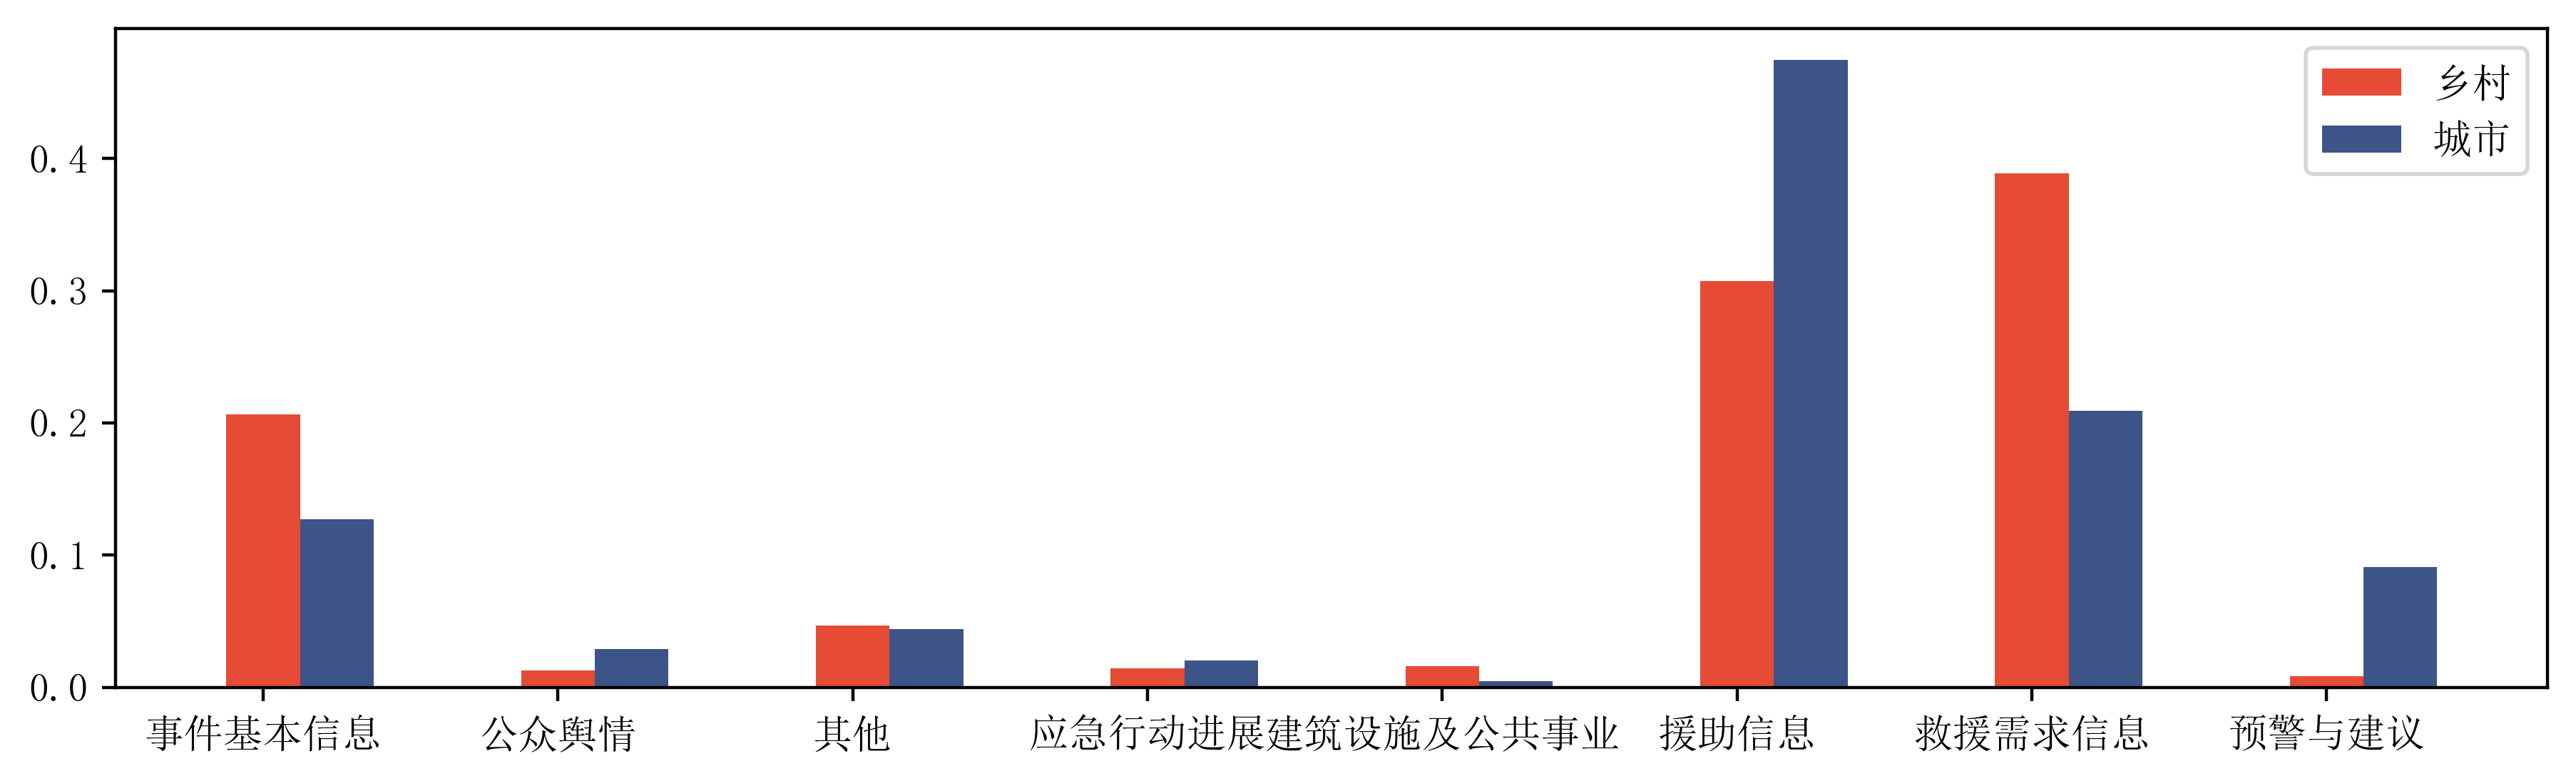

In [104]:
fig, ax = plt.subplots(1,1, figsize=(11,3),dpi=400)
x = np.arange(len(weibo_not_xians_topicI_distribution)) # x轴刻度标签位置
width = 0.25 # 柱子的宽度

ax.bar(x - width, list(weibo_xians_topicI_distribution), width, color='#E64B35FF',label='乡村',tick_label=weibo_xians_topicI_distribution.index)
ax.bar(x, list(weibo_not_xians_topicI_distribution), width,color='#3C5488FF', label='城市')
ax.legend()

### 需求主题分布差异

（需求B1一般救援需求B2物资需求B3寻人需求B4紧急转移需求）

In [99]:
demands_index = ['一般救援需求','应急物资需求','人员搜寻需求','紧急转移需求']

In [100]:
weibo_xians_topicII_ts = get_topic_ts(weibo_xians_add_cun[phase_1_2_xians],topic_lv=2)[['B1','B2','B3','B4']]
weibo_not_xians_topicII_ts = get_topic_ts(weibo_not_xians[phase_1_2_not_xians],topic_lv=2)[['B1','B2','B3','B4']]

需求类微博占当时段微博的比例

In [101]:
print('需求类微博占比')
print('xian', weibo_xians_topicII_ts.sum().sum()/sum(phase_1_2_xians))
print('not xian', weibo_not_xians_topicII_ts.sum().sum()/sum(phase_1_2_not_xians))

需求类微博占比
xian 0.38884895779854195
not xian 0.20915377402719174


In [102]:
demand_distribution_xians = weibo_xians_topicII_ts.sum()/weibo_xians_topicII_ts.sum().sum()
demand_distribution_not_xians = weibo_not_xians_topicII_ts.sum()/weibo_not_xians_topicII_ts.sum().sum()

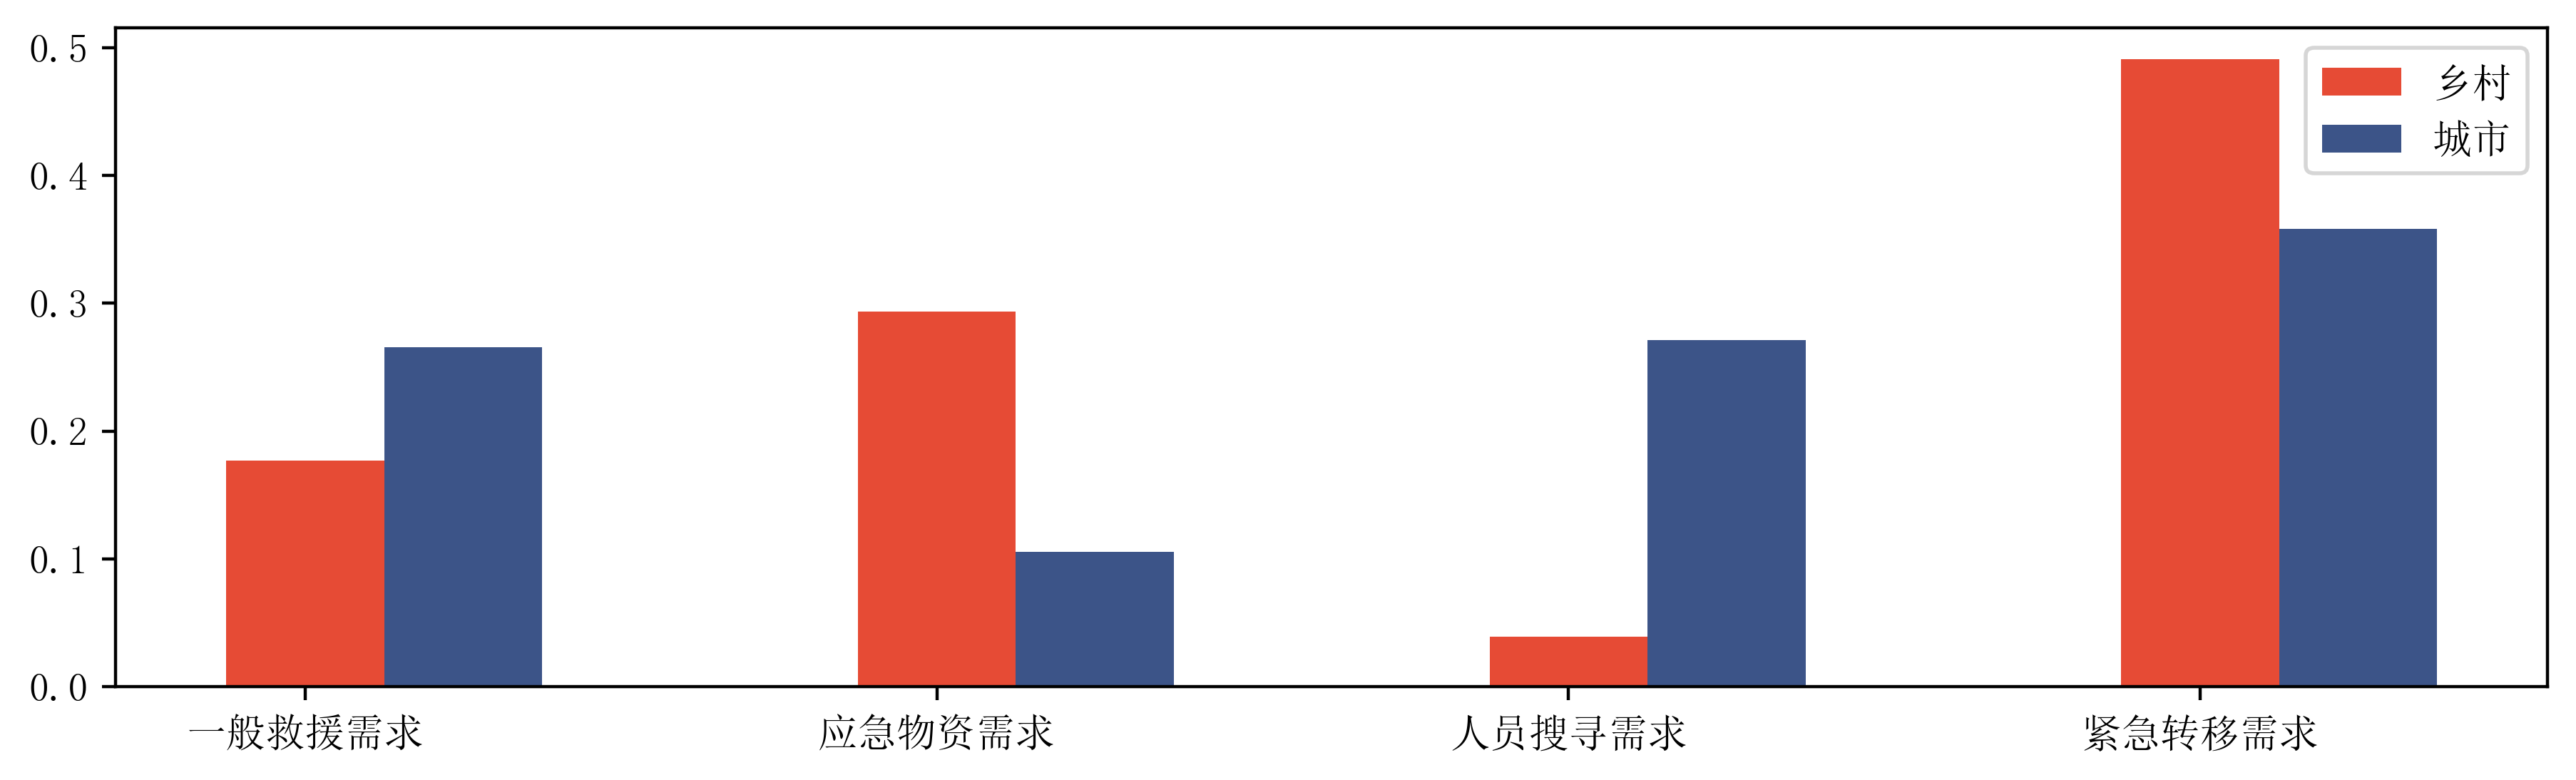

In [103]:
fig, ax = plt.subplots(1,1, figsize=(11,3),dpi=400)
x = np.arange(len(demand_distribution_not_xians)) # x轴刻度标签位置
width = 0.25 # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# x - width/2，x + width/2即每组数据在x轴上的位置
# ax.bar(x - width/2, list(demand_distribution_xians), width, label='xian',tick_label=demand_distribution_xians.index)
# ax.bar(x + width/2, list(demand_distribution_not_xians), width, label='not xian')
# #E64B35FF','#4DBBD5FF','#00A087FF','#3C5488FF'
ax.bar(x - width, list(demand_distribution_xians), width, color='#E64B35FF',label='乡村',tick_label=demands_index)
ax.bar(x, list(demand_distribution_not_xians), width,color='#3C5488FF', label='城市')
ax.legend()


需求子类对应，一般救援需求，物资需求，寻人需求，紧急转移需求的比例；<br>
县： 物资需求、紧急转移占比高于城市；<br>
市区： 一般救援需求与寻人需求占比多于乡村

#### 寻人需求

In [ ]:
random.seed(42)
random.choices(weibo_xians_1[phase_1_2_xians & (weibo_xians_1['topic_II']=='B3')]['content'].tolist(), k=50)

#### 物资需求

In [ ]:
random.seed(42)
random.choices(weibo_xians_1[phase_1_2_xians & (weibo_xians_1['topic_II']=='B2')]['content'].tolist(), k=10)

In [ ]:
!pip install jieba

In [ ]:
import jieba
# text = '今天我想回家'
# list(jieba.cut(text, cut_all=False))
jieba.add_word('无纺土工布')
jieba.add_word('反渗水布')
jieba.add_word('编织袋')
jieba.add_word('防洪墙')

In [ ]:
import jieba
from collections import Counter

def word_frequency(list_texts):
    words_list = list(map(lambda text: jieba.cut(text, cut_all=False), list_texts))
    new = []
    for lst in words_list:
        new += lst
    
    word_frequencies = Counter(new)
    return word_frequencies
        

In [ ]:
word_f = word_frequency(weibo_xians_add_cun[phase_1_2_xians & (weibo_xians_add_cun['topic_II']=='B2')]['content'].tolist())

In [ ]:
word_f.most_common(150)

In [ ]:
word_f_not_xian = word_frequency(weibo_not_xians[phase_1_2_not_xians & (weibo_not_xians['topic_II']=='B2')]['content'].tolist())

In [ ]:
word_f_not_xian.most_common(150)

In [ ]:
random.seed(42)
random.choices(weibo_xians_1[phase_1_2_xians & (weibo_xians_1['topic_II']=='B2')]['content'].tolist(), k=50)

In [ ]:
random.seed(42)
random.choices(weibo_not_xians_1[phase_1_2_not_xians & (weibo_not_xians_1['topic_II']=='B2')]['content'].tolist(), k=10)

In [ ]:
random.seed(42)
random.choices(weibo_not_xians_1[phase_1_2_not_xians & (weibo_not_xians_1['topic_II']=='B2')]['content'].tolist(), k=50)

#### 紧急救援需求

看下具体微博，具体的需求描述：

In [ ]:
random.seed(42)
random.choices(weibo_xians_1[phase_1_2_xians & (weibo_xians_1['topic_II']=='B4')]['content'].tolist(), k=10)

In [ ]:
random.seed(42)
random.choices(weibo_not_xians_1[phase_1_2_not_xians & (weibo_not_xians_1['topic_II']=='B4')]['content'].tolist(), k=10)

### 需求内情感分布

没有太多区分；

In [ ]:
weibo_xians_demand_senti_ts = get_senti_ts(weibo_xians[weibo_xians['topic_I']=='Help'])

In [ ]:
weibo_not_xians_demand_senti_ts = get_senti_ts(weibo_not_xians[weibo_not_xians['topic_I']=='Help'])

In [ ]:
senti_distribution_not_xian_demand = np.sum(weibo_not_xians_demand_senti_ts, axis=0)/np.sum(np.sum(weibo_not_xians_demand_senti_ts, axis=0))
senti_distribution_xian_demand = np.sum(weibo_xians_demand_senti_ts, axis=0)/np.sum(np.sum(weibo_xians_demand_senti_ts, axis=0))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
x = np.arange(len(senti_distribution_xian_demand)) # x轴刻度标签位置
width = 0.25 # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# x - width/2，x + width/2即每组数据在x轴上的位置
ax.bar(x - width/2, list(senti_distribution_xian_demand), width, label='xian',tick_label=senti_distribution_xian_demand.index)
ax.bar(x + width/2, list(senti_distribution_not_xian_demand), width, label='not xian')
ax.legend()

### 需求+城乡+地点统计可视化

统计思路，城按城统计，乡按乡统计；即城微博只匹配城地名，乡微博只匹配乡地名，按content去匹配地点关键词；
<br>
第二步，要把表做一个映射，匹配用简化名称，存的时候要用标准化的地点名；

In [ ]:
# 城与乡
weibo_xians_add_cun.shape
weibo_not_xians.shape

# 划分依据
print(districts_xian_for_match_new)
print(districts_not_xian_for_match)

#### 按天，按主题进行统计

In [ ]:
admin_file = open_json('./data/results/admin_divisions.json')

In [ ]:
henan_districts = list(filter(lambda district: district[0][:2] == '41', admin_file.get('district')))

In [ ]:
henan_districts

In [ ]:
weibo_not_xians.columns

In [ ]:
dis_map = {}
for dis in henan_districts:
    for dis_2 in (districts_xian_for_match_new + districts_not_xian_for_match):
        if dis_2 in dis[1]:
            dis_map[dis_2] = dis[1]



In [ ]:
dis_map

In [ ]:
def pipeline(topic, date, dis='urban'):
    stats = {}
    if dis == 'urban':
        df = weibo_not_xians
        districts_simple = districts_not_xian_for_match
    else:
        df = weibo_xians_add_cun
        districts_simple = districts_xian_for_match_new
        
    df = df.loc[(df.topic_II == topic) & (df.publish_time.apply(lambda x: x.strftime("%Y-%m-%d") == date))]
    print(df.shape)
    for district in  :
        count = len(list(filter(lambda add: district in add, df.content.tolist())))
#         stats[dis_map[district]] = (count,dis)
        stats[dis_map[district]] = count
    print(sum(stats.values()))
    save_as_json(stats,f'./data/results/address/stats_{topic}_{date}_{dis}.json')

In [ ]:
topics_list = ['B1','B2','B3','B4',]
phases = [
    '2021-07-19',
    '2021-07-20',
    '2021-07-21',
    '2021-07-22',
    '2021-07-23',
    '2021-07-24',
    '2021-07-25',
]

for topic, phase in itertools.product(topics_list, phases):
    pipeline(topic=topic, date=phase, dis='village')

In [ ]:
sum(weibo_not_xians.topic_I == 'Help')

In [ ]:
sum((weibo_not_xians.topic_I == 'Help') & (weibo_not_xians.phase == '1'))

In [ ]:
sum((weibo_xians_add_cun.topic_I == 'Help') & (weibo_xians_add_cun.phase == '1'))

In [ ]:
topics_list = ['B1','B2','B3','B4',]
phases = [
    '2021-07-19',
    '2021-07-20',
    '2021-07-21',
    '2021-07-22',
    '2021-07-23',
    '2021-07-24',
    '2021-07-25',
]

for topic, phase in itertools.product(topics_list, phases):
    pipeline(topic=topic, date=phase, dis='urban')

In [ ]:
weibo_xians_add_cun.topic_II.value_counts()

In [ ]:
weibo_not_xians.loc[(weibo_not_xians.topic_I == 'Help') & (weibo_not_xians.phase == '1')]

#### 按b4紧急转移需求，统计城乡时空变化

In [ ]:
color_panel = ['#E64B35FF','#4DBBD5FF','#00A087FF','#3C5488FF','#F39B7FFF','#8491B4FF',
               '#91D1C2FF','#DC0000FF','7E6148FF','B09C85FF']

In [ ]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 

In [ ]:
import geopandas as gpd
import mapclassify
import matplotlib.colors as colors

In [ ]:
districts_china = gpd.read_file('/Users/roccc/Desktop/Projects/DataAnalysis/GeoVisualization/GeoData/China-District-202208/district.shp')

In [ ]:
districts_china.columns

In [ ]:
districts_china.pr_adcode[:5]

In [ ]:
def load(file):
    henan = districts_china.loc[districts_china.pr_name.isin(['河南省']), ['dt_name', 'geometry']]
    henan.drop_duplicates(inplace=True)
    henan.columns = ['name', 'geometry']
    henan_number = open_json(file)
    henan_number_df = pd.DataFrame({'name':henan_number.keys(), 'number':henan_number.values()})
    henan = henan.merge(henan_number_df, on='name')
    return henan

In [ ]:
def geo_evlov_topic_day_urban(topic, num_days=5, cmap='Reds', fontsize=12,norm='None', vmax=10000, figsize=12):
    """
    b1,b2,b3,b4
    start with 2021-07-20
    """
    fig, axes = plt.subplots(1,num_days, figsize=(figsize, figsize/num_days), dpi=300)
    if norm == 'log':
        norm_ = colors.LogNorm(vmin=1, vmax=vmax)
    elif norm == 'norm':
        norm_ = colors.Normalize(vmin=0, vmax=vmax)
    else:
        norm_ = None
    
    for i, ax in enumerate(axes):
        day = '2021-07-'+str(20+i)
        filepath_1 = f"./data/results/address/stats_{topic}_{day}_urban.json"
        filepath_2 = f"./data/results/address/stats_{topic}_{day}_village.json"
        data_1 = load(filepath_1)
#         print(data_1.number)
#         break
        data_2 = load(filepath_2)
        data_1.plot(
            column='number',linewidth=0.5, edgecolor='0.5', ax=ax,
            cmap='Blues', norm=norm_
        )
        data_2.plot(
            column='number',linewidth=0.5, edgecolor='0.5', ax=ax,
            cmap='Reds', norm=norm_
        )
        ax.axis('off')

#         # label 
#         for index, row in data_1.iterrows():
#             xy = row['geometry'].centroid.coords[:]
#             xytext = row['geometry'].centroid.coords[:]

        #  title
        ax.set_title(f'{day}', fontdict={'fontsize': fontsize, 'fontweight': '1'})

    sm = plt.cm.ScalarMappable(cmap=cmap)
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
    
    cbar = fig.colorbar(sm, cax=cbar_ax)
#     cbar = fig.colorbar(ax3, ax=ax3)
#     cbar.set_ticks([0,1,10,100,1000,10000])
#     cbar.set_ticklabels(['0','1', '10', '100','1000','10000'])
    plt.show()

In [ ]:
topic_evlov_geo_day('B4',norm='norm',vmax=100)

In [ ]:
topic_evlov_geo_day('B1',norm='norm',vmax=100)

In [ ]:
topic_evlov_geo_day('B2',norm='norm',vmax=50)